Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

I'll use SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset fro protein and ligand modeling and consists of 642 experimental values logP.

The overall structure of the multimodal fused deep learning (MMFDL) model. Blue, orange and green color lines represent the data flow in the model for training, tuning, and test sets. SMILES-encoded vectors are processed by Transformer-Encoder, ECFP is processed by BiGRU with MultiHead Attention, and Graph is processed by GCN model. The training set is used to train the feature extraction model; the validation set determines the hyperparameters of the feature extraction model. The tuning set is used to assign the weights for each modal input. The test set is used to validate the prediction performance.

In this part, we compute the weights of the different models after splicing the three learned multimodal feature outputs using numeric method for combination, which is refered to as Tri_SGD.

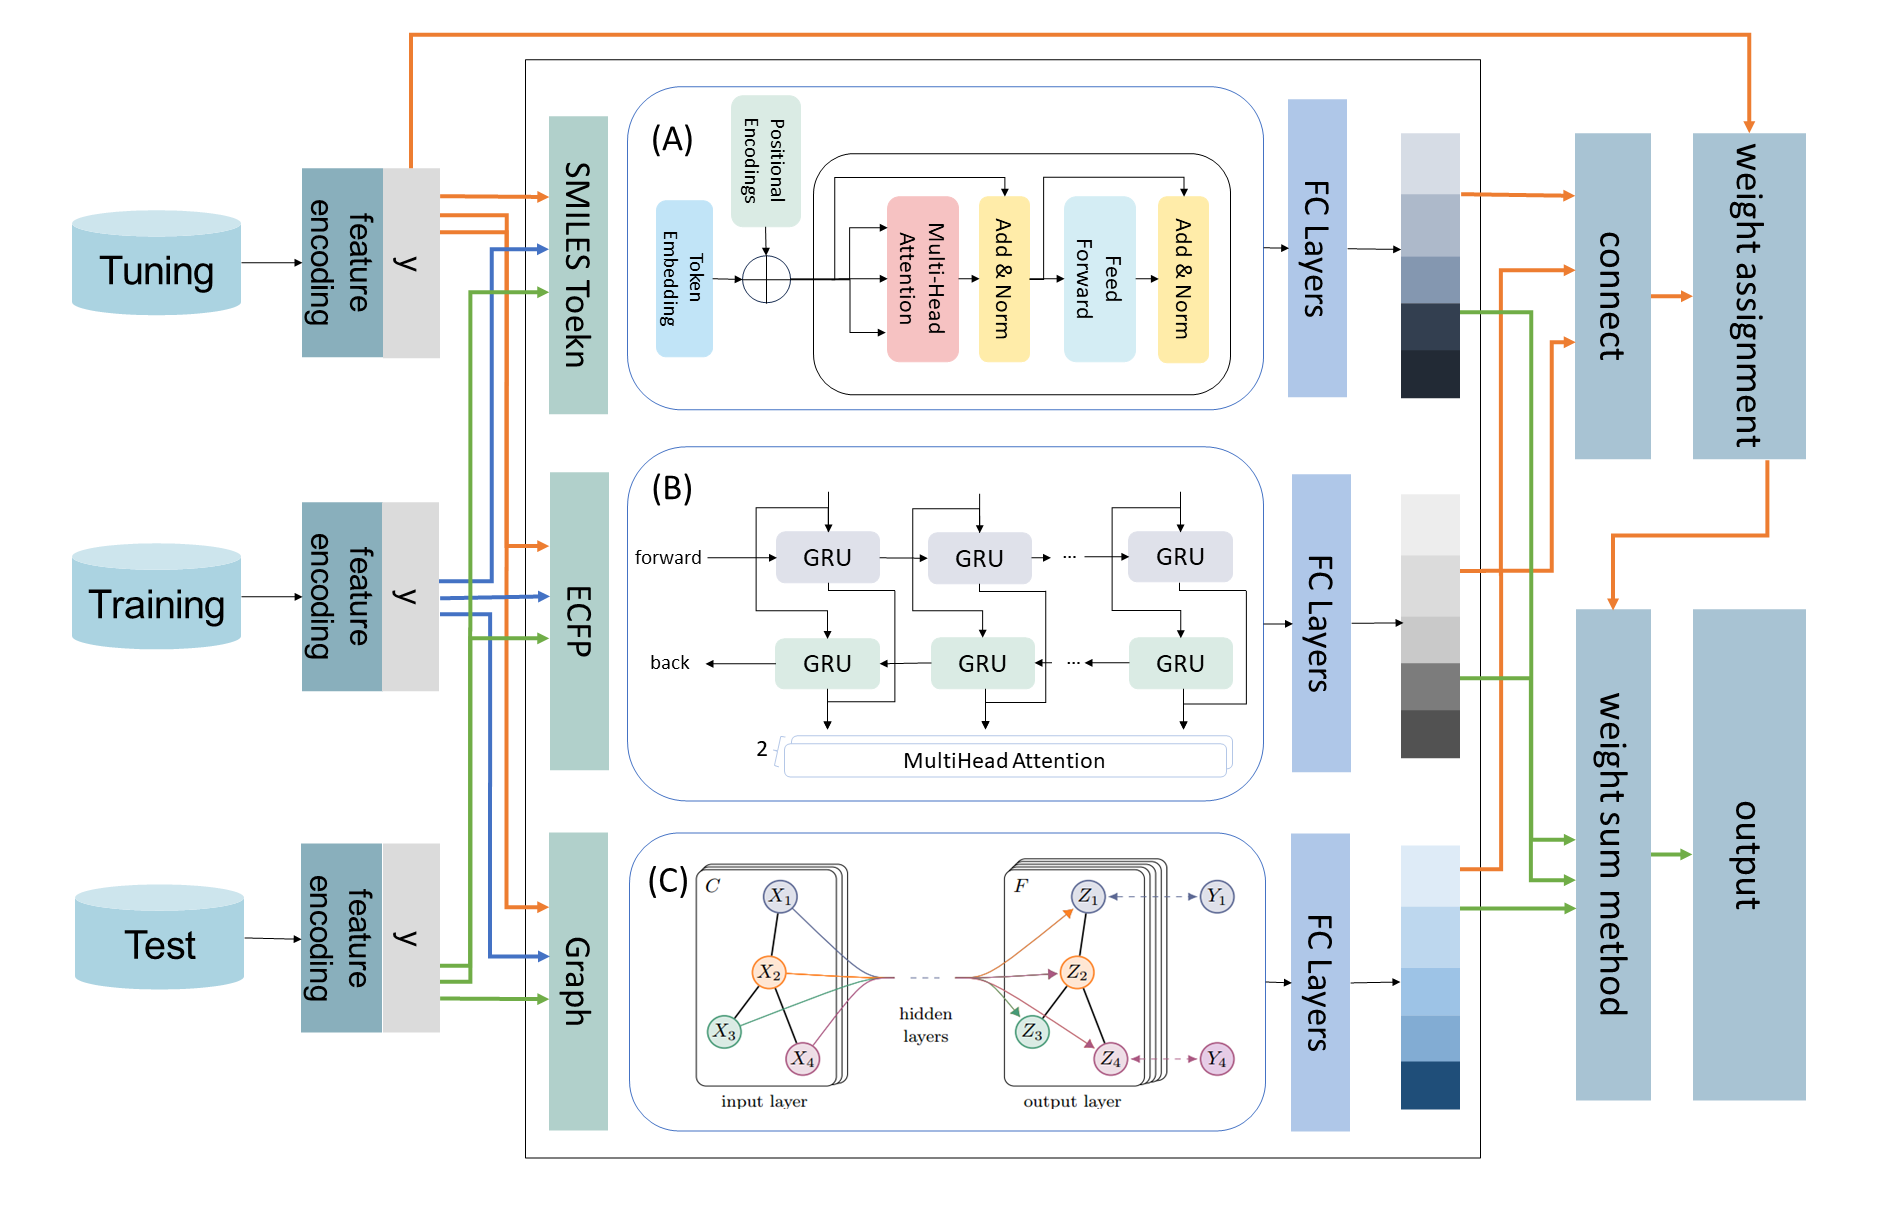

In [1]:
from PIL import Image
from IPython.display import display
img = Image.open('MMFDL_model.png')
display(img)

Prepare training data and testing data.

In [2]:

# from myTrCPI.script.makeModel.utils_smiecfp import *
from sklearn import metrics
# from torch.utils.data import Dataset, DataLoader
# from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import warnings
from sklearn.linear_model import ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sys

sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from analysis import *
from utils import *

sys.path.append('../model')
from model_combination import *

warnings.filterwarnings("ignore", category=UserWarning, module="torch_geometric")

gpu_index = 0  # 可以根据需要更改为其他 GPU 编号

# 检查是否有可用的 GPU 设备
if torch.cuda.is_available():
    # 设置为指定的 GPU 设备
    device = torch.device(f'cuda:{gpu_index}')
else:
    # 如果没有可用的 GPU，使用 CPU
    device = torch.device('cpu')




epochs = 50
batch_size = 16
label = 10000
random_state= 42

argsCom = {
    'num_features_smi': 44,
    'num_features_ecfp':1024,
    'num_features_x': 78,
    'dropout': 0.1, 
    'num_layer': 4,
    'num_heads': 4,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1
    
}

resultLoss = {'losses_train': [], 'losses_val': []}

train_data = formDataset(root='../dataSour', dataset='data_train')
train_ratio = 0.8
num_data = len(train_data)
indices = list(range(num_data))
train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True, random_state=random_state)
train_dataset = [train_data[i] for i in train_indices]
val_dataset = [train_data[i] for i in val_indices]
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data = formDataset(root='../dataSour', dataset='data_test')
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)


Pre-processed data found: ../dataSour/processed/data_train.pt, loading ...
Pre-processed data found: ../dataSour/processed/data_test.pt, loading ...


Extracting features from different representations

In [12]:
learning_rate = 0.0001
com_model = comModel(argsCom).to(device)
optimizer_com = torch.optim.Adam(com_model.parameters(), lr=learning_rate)
criterion_com = torch.nn.MSELoss()

com_model.train()
for i in range(epochs):
    
    print("Running EPOCH",i+1)
    total_loss = 0
    n_batches = 0
    correct = 0
    '''
        train部分
    '''
    for batch_idx, data in enumerate(trainLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
        
        loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss = (loss1 + loss2 + loss3) / 3
        total_loss += (loss.data)/3
        optimizer_com.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(com_model.parameters(),0.5)
        optimizer_com.step()
        n_batches+=1
        torch.cuda.empty_cache()
    avg_loss = total_loss / n_batches
    resultLoss['losses_train'].append(avg_loss)
    print('train avg_loss is: ', avg_loss.item())

    '''
        val部分
    '''
    total_loss = 0
    n_batches = 0
    correct = 0
    for batch_idx, data in enumerate(valLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch) 
        loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss = (loss1 + loss2 + loss3) / 3
        total_loss += (loss.data)/3
        optimizer_com.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(com_model.parameters(),0.5)
        optimizer_com.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_val'].append(avg_loss) 
    print('val avg_loss is: ', avg_loss.item())
    print('\n')

val_data = []
pred_data1 = []
pred_data2 = []
pred_data3 = []
com_model.eval()
for batch_idx, data in enumerate(valLoader):
    encodedSmi = torch.LongTensor(data.smi).to(device)
    encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
    ecfp = torch.FloatTensor(data.ep).to(device)
    y = data.y.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)
    y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
    val_data.append(y.tolist())
    pred_data1.append(y_pred[0].tolist())
    pred_data2.append(y_pred[1].tolist())
    pred_data3.append(y_pred[2].tolist()) 

def flattened_data(data):
    fla_data = [item for sublist in data for item in sublist]
    merged_data = np.array(fla_data).flatten() 
    return merged_data

# 为了写入val预测值和真实值
data_ = {}
data_['pred1'] = flattened_data(pred_data1)
data_['pred2'] = flattened_data(pred_data2)
data_['pred3'] = flattened_data(pred_data3)
data_['true'] = flattened_data(val_data)

# 做权重分析
val_data = flattened_data(val_data).astype(np.float32)
pred_data1 = flattened_data(pred_data1).astype(np.float32)
pred_data2 = flattened_data(pred_data2).astype(np.float32)
pred_data3 = flattened_data(pred_data3).astype(np.float32)

learning_rate_weight = 0.01
weights = torch.tensor([0.7, 0.2, 0.1], requires_grad=True, dtype=torch.float)
optimizer_weight = torch.optim.SGD([weights], lr=learning_rate_weight)
criterion_weight = nn.MSELoss()

val_data_tensor = torch.from_numpy(val_data)
pred_data1_tensor = torch.from_numpy(pred_data1)
pred_data2_tensor = torch.from_numpy(pred_data2)
pred_data3_tensor = torch.from_numpy(pred_data2)
for i in range(epochs):
    print("Running EPOCH", i+1)
    if weights.data.sum() > 1:
        # 如果总和大于1，进行归一化处理
        weights.data /= weights.data.sum()
    # Compute weighted_output using torch operations, not .detach().numpy()
    weighted_output = (weights[0] * pred_data1_tensor + weights[1] * pred_data2_tensor + weights[2] * pred_data3_tensor).to(device)
    val_output = val_data_tensor.to(device)
    loss = criterion_weight(weighted_output, val_output)
    optimizer_weight.zero_grad()
    loss.backward()
    optimizer_weight.step()
    print('weight loss is: ', loss.item())
print('\n')


# 为了写入权重
numpy_weights = weights.detach().numpy()
weightDic = {}
weightDic[1] = numpy_weights[0]
weightDic[2] = numpy_weights[1]
weightDic[3] = numpy_weights[2]
print(weightDic)


def calRmseMae(y, y_pred):
    yResult = {}
    ground_truth = y
    predictions = y_pred
    # calculate rmse
    squared_errors = (ground_truth - predictions) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    yResult['rmse'] = rmse
    # calculate mae
    absolute_errors = np.abs(ground_truth - predictions)
    mae = np.mean(absolute_errors)
    yResult['mae'] = mae
    return yResult

sour_data = []
pred_data1 = []
pred_data2 = []
pred_data3 = []

com_model.eval()
for batch_idx, data in enumerate(testLoader):
    encodedSmi = torch.LongTensor(data.smi).to(device)
    encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
    ecfp = torch.FloatTensor(data.ep).to(device)
    y = data.y.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)
    y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)  
    sour_data.append(y.tolist())
    pred_data1.append(y_pred[0].tolist())
    pred_data2.append(y_pred[1].tolist())
    pred_data3.append(y_pred[2].tolist()) 
yPred = numpy_weights[0] * flattened_data(pred_data1) + numpy_weights[1] * flattened_data(pred_data2) + numpy_weights[2] * flattened_data(pred_data3)
ySour = flattened_data(sour_data)

yResult = {}
yResult['result'] = calRmseMae(ySour, yPred)
print(yResult)
print('\n')

Running EPOCH 1
train avg_loss is:  8.570166743162504
val avg_loss is:  5.850031471878833


Running EPOCH 2
train avg_loss is:  7.124666055922657
val avg_loss is:  4.855729417238081


Running EPOCH 3
train avg_loss is:  6.0228688318808
val avg_loss is:  4.29041212478258


Running EPOCH 4
train avg_loss is:  5.301874214548062
val avg_loss is:  3.7635049686805004


Running EPOCH 5
train avg_loss is:  4.833874425896722
val avg_loss is:  3.417472257984314


Running EPOCH 6
train avg_loss is:  4.377110905435179
val avg_loss is:  3.1859776038309633


Running EPOCH 7
train avg_loss is:  4.153065958724951
val avg_loss is:  3.086054638514259


Running EPOCH 8
train avg_loss is:  4.007617163483457
val avg_loss is:  2.920103099568921


Running EPOCH 9
train avg_loss is:  4.094744585721204
val avg_loss is:  2.885432280821096


Running EPOCH 10
train avg_loss is:  3.71066000486772
val avg_loss is:  2.781503306615872


Running EPOCH 11
train avg_loss is:  3.6211818982931256
val avg_loss is:  2.71347

Save results

pearson:  (0.9338000722007807, 1.4687499933436335e-36)
0.8834947709728609 0.9338000722007807


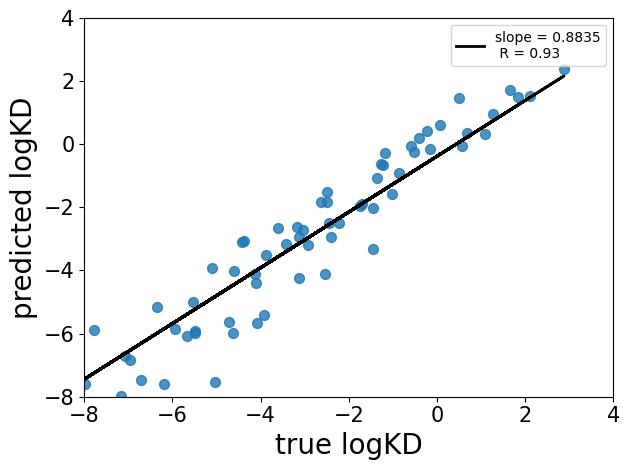



../result/SGD/10000-result-16-50-42-com.csv	saved successfully


../result/SGD/10000_validation_16_50_42_data.csv	save succeed!


In [13]:
savePath = '../result/SGD/{}_rmseMae_{}_{}_{}_weight_com.csv'.format(label, batch_size, epochs, random_state)
rmseAndMae(yResult, savePath)
savePath = '../result/SGD/{}_weight_{}_{}_{}_weight_com.csv'.format(label, batch_size, epochs, random_state)
df_weight = pd.DataFrame(weightDic.items(), columns=['Key', 'Value'])
df_weight.to_csv(savePath, index=False)

savePath = '../result/SGD/{}_scatter_predited_{}_{}_{}_com.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(yPred, ySour, savePath)

print('\n')

result = {}
result['y_pred'] = yPred
result['y'] = ySour
resultPath = '../result/SGD/{}-result-{}-{}-{}-com.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')
print('\n')

savePath = '../result/SGD/{}_loss_{}_{}_{}_weight_com.png'.format(label, batch_size, epochs, random_state)

savePath = '../result/SGD/{}_validation_{}_{}_{}_data.csv'.format(label, batch_size, epochs, random_state)
data_as_lists = {key: data_[key].tolist() for key in data_}
df_data = pd.DataFrame(data_as_lists)
df_data.to_csv(savePath, index=False)
print(savePath + '\tsave succeed!')
